<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "PIR"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/BrainStructures/PIR/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


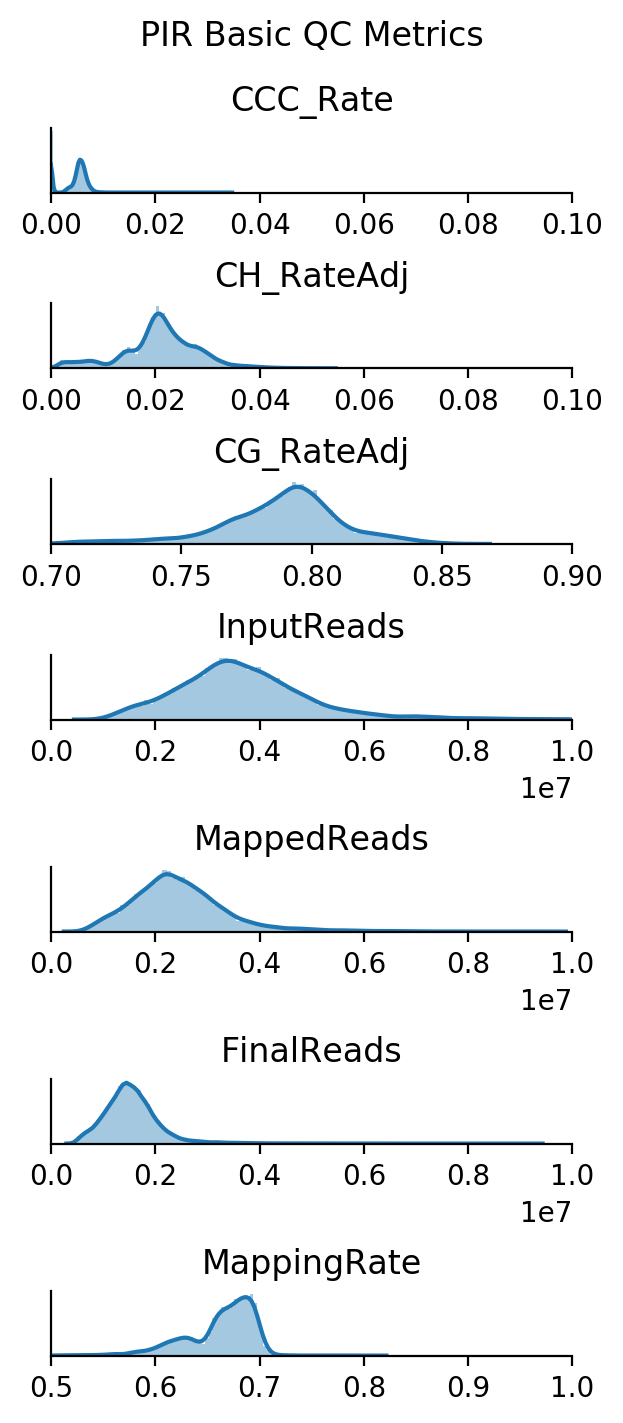

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

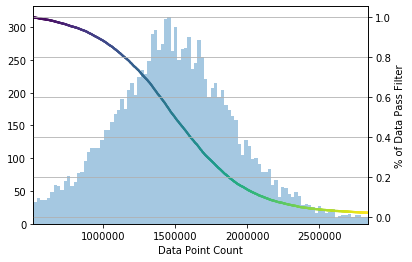

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 12595/12595 (100.0%)
CG_RateAdj passed 12595/12595 (100.0%)
CH_RateAdj passed 12595/12595 (100.0%)
FinalReads passed 12595/12595 (100.0%)
MappingRate passed 12595/12595 (100.0%)
Overall passed 12595/12595 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
180313 519
180319 304
180320 1334
180326 1182
180329 1315
180402 1240
180403 1564
181008 1296
181009 1302
190131 1213
190205 1326


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 1589 413.8%
ad002 1615 420.6%
ad004 1620 421.9%
ad006 1599 416.4%
ad007 1571 409.1%
ad008 1593 414.8%
ad010 1523 396.6%
ad012 1485 386.7%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
2D_M_0,/gale/raidix/rdx-4/CEMBA_RS1/2D/CEMBA180313_2D...,0.004380,0.764630,0.763590,0.021850,0.017550,972938.0,2068402,1380373.0,2D,...,0.458792,-10.150439,-17.991576,36.526457,IT-L23 Cux1,1.846170,3.197297,16.376167,6.809280,True
2D_M_1,/gale/raidix/rdx-4/CEMBA_RS1/2D/CEMBA180313_2D...,0.005160,0.786500,0.785390,0.026030,0.020980,1074683.0,2310124,1532624.0,2D,...,-0.247123,11.410120,15.156283,-53.981018,OLF-Exc Lrrtm3,4.112866,-2.737988,-28.179672,28.777648,True
2D_M_10,/gale/raidix/rdx-4/CEMBA_RS1/2D/CEMBA180313_2D...,0.004730,0.789810,0.788810,0.023770,0.019130,699756.0,1534520,1008756.0,2D,...,12.087256,-0.696364,56.674637,-3.683435,CLA Cdh8,-1.197910,-6.802081,11.014825,-14.352364,True
2D_M_100,/gale/raidix/rdx-4/CEMBA_RS1/2D/CEMBA180313_2D...,0.005060,0.805750,0.804760,0.024230,0.019270,1030854.0,2374550,1534642.0,2D,...,4.092578,3.497804,31.332601,-29.550220,OLF-Exc Bmpr1b,10.088137,-12.622199,-16.164262,-40.993664,True
2D_M_1000,/gale/raidix/rdx-4/CEMBA_RS1/2D/CEMBA180319_2D...,0.004960,0.778290,0.777180,0.024280,0.019420,1412334.0,3233830,2166455.0,2D,...,-5.505295,9.229610,48.358495,-3.209748,OLF-Exc Sgcd,-4.111145,4.515373,37.716487,19.505981,True
2D_M_1001,/gale/raidix/rdx-4/CEMBA_RS1/2D/CEMBA180319_2D...,0.005730,0.776700,0.775410,0.026000,0.020390,2609047.0,5875090,3985732.0,2D,...,-0.681241,5.680912,32.339936,-45.636817,OLF-Exc Bmpr1b,9.123264,-5.138564,20.133521,-11.584748,True
2D_M_1002,/gale/raidix/rdx-4/CEMBA_RS1/2D/CEMBA180319_2D...,0.006100,0.806400,0.805210,0.030260,0.024310,1505830.0,3445668,2316514.0,2D,...,-6.267752,9.791952,47.696074,-8.568575,OLF-Exc Sgcd,-2.991959,4.054504,28.479991,16.407822,True
2D_M_1003,/gale/raidix/rdx-4/CEMBA_RS1/2D/CEMBA180319_2D...,0.003760,0.772850,0.771990,0.012450,0.008720,3179539.0,7146282,4892336.0,2D,...,-1.730975,-3.614243,-3.458112,-32.069433,OLF Outlier,3.269973,16.315372,-9.652421,4.449600,True
2D_M_1004,/gale/raidix/rdx-4/CEMBA_RS1/2D/CEMBA180403_2D...,0.006700,0.827850,0.826690,0.038280,0.031790,1526309.0,3554830,2376480.0,2D,...,-21.424152,0.522630,-31.286009,-12.255798,MGE-Sst Bmper,-3.484929,-11.807238,11.738538,24.183154,True
2D_M_1005,/gale/raidix/rdx-4/CEMBA_RS1/2D/CEMBA180403_2D...,0.006080,0.799860,0.798640,0.029640,0.023700,1668726.0,3918040,2608355.0,2D,...,-6.281798,9.939112,48.436693,-7.504155,OLF-Exc Sgcd,-3.497566,4.771543,32.539832,17.048028,True
